# Weather Data Analysis
### Simon Lindqvist, mail: siln22@student.bth.se
### Abdalrahman Mohammed, mail: abmm22@student.bth.se

### General imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import statistics as stats
import math
import scipy.stats as st
from scipy.stats import zscore


# Read the csv file into a pandas dataframe
smhi_df = pd.read_csv("./Data analysis\Weather Data Analysis\dataset\SMHI_Data.csv")

The first step is to import all libraries and dependencies that will be used when performing this data analysis. The database, in this case a csv file, is also read and stored as a pandas dataframe.

### Explain the data cleaning steps you consider for analyzing the provided dataset. You must motivate and describe why, how, and in which order you are going to apply the selected steps to the dataset.

The chosen data cleaning steps are as follows:
1. Create copy for cleanign in order to preserve original data
2. Handle duplicates
3. Handle missing values
4. Handle outliers
5. Normalize data

In [4]:
# Create a copy of the dataframe to clean
smhi_df_cleaned = smhi_df.copy()

# Remove duplicates since they do not add any information (the same time can obviosuly not occur more than once)
smhi_df_cleaned.drop_duplicates(inplace=True)

# For missing data we will take the mean (linear interpolation) of the previous and next value, since temperature is likely to be a smooth function
smhi_df_cleaned["Lufttemperatur"] = smhi_df_cleaned["Lufttemperatur"].interpolate(method="linear");

# Handle outliers using z-scores. Outliers should be interpolated since we cannot remove data from a time series.
z_scores = zscore(smhi_df_cleaned["Lufttemperatur"])
abs_z_scores = np.abs(z_scores)
# When finding a outlier, remove the temperature value so we can interpolate is later
smhi_df_cleaned["Lufttemperatur"] = np.where(abs_z_scores > 3, np.nan, smhi_df_cleaned["Lufttemperatur"]) # 3 should handle the 1% most extreme values
# Save numbers of outliers removed
number_outliers_removed = len(smhi_df_cleaned["Lufttemperatur"]) - len(smhi_df_cleaned["Lufttemperatur"].dropna())
#Interpolate the now non existing values where outliers where before
smhi_df_cleaned["Lufttemperatur"] = smhi_df_cleaned["Lufttemperatur"].interpolate(method="linear");

# Normalize data
smhi_df_cleaned["Datum"] = pd.to_datetime(smhi_df_cleaned["Datum"])
smhi_df_cleaned["Tid (UTC)"] = pd.to_datetime(smhi_df_cleaned["Tid (UTC)"])
smhi_df_cleaned["Lufttemperatur"] = pd.to_numeric(smhi_df_cleaned["Lufttemperatur"])


The first step is to create a copy of the original dataset which will be used when performing the cleaning steps. This is done in order to ensure intregrity of the original dataset and provide easy access to unaltered data if needed. Then all duplicates are dropped, since they do not provide any value in a time series (since the same time logically cannot occur more than once, and duplicate). Duplicate data also risks any histograms showing the wrong picture, since certain bins would be artificially added to. 

The third step is to handle any missing values. This is a very crucial step since our dataset is a time series. We can't just remove missing values, since it would alter and provide gaps in our time series. Since temperature naturally gradually decreases or increases an interpolation method was chosen to hanlde the missing values. The inerpolation will linearly replace missing values, which should be the mean of the previous and next value in case of a single missing value.

The fourth step is to handle any outliers. We have chosen to define outliers as any values with z-scores above 3. This should get us the 1% most extreme values, which is deemed as a sound number because of reasons discussed in question 8. When finding outliers, these values where set to None, so we could use the interpolation method on these newly created empty spaces to interpolate new values more in line with the rest of the data. It's important to not just remove the outliers outright, since we must preserve the integrity of the time series.

Lastly the data is normalized just in case there are any differences in the data. This shouldn't be a problem though, since the data is from SMHI, which operates in a single country and probably adheres to a certain format for all of their data.

### Does the dataset contain any missing values? If so, how many in both absolute terms and percentages? Reflect on the number of missing values. Do you regard it as much or not?

In [5]:
missing_date, missing_time, missing_temp = smhi_df.isnull().sum()
total_entries = len(smhi_df)
print(f"Total entries in dataset = {total_entries}\n")

date_missing_percent = missing_date/total_entries
time_missing_percent = missing_time/total_entries
temp_missing_percent = missing_temp/total_entries

print(f"Date data has {missing_date} missing values, which is {date_missing_percent * 100} percent of all date entries\n")
print(f"Time data has {missing_time} missing values, which is {time_missing_percent * 100} percent of all date entries\n")
print(f"Temperature data has {missing_temp} missing values, which is {round(temp_missing_percent, 4) * 100} percent of all date entries")

Total entries in dataset = 122856

Date data has 0 missing values, which is 0.0 percent of all date entries

Time data has 0 missing values, which is 0.0 percent of all date entries

Temperature data has 7237 missing values, which is 5.89 percent of all date entries


About 6% missing values is a moderate amount, actually above the 5% limit that generally is spoken of when it comes to acceptable levels of missing values. However it is also worth noting which type of data that is considered. When it comes to temperature data, it should be easy enough to fill any empty values by for example using some form of interpolation (since temperature gradually changes over time). So even though we might have a slightly worse percentage than the general consensus on amount of missing values, we assume it has less of an impact in this case specifically due to the nature of temperature changes and it's data.

### Which strategy was used for handling the missing values? Motivate why you consider the selected strategy the most suitable for this task.

When it comes to handling the missing values, linear interpolation was chosen. This choice was made because it was the method deemed most alike how temperature normally behaves. Temperature always gradually changes based on factors such as naerby temperature differences. When two objects with different temperature have a similar temperature, this process is slow, but when the differences are larger the process becomes faster. This should translate to missing values too. For example if the value before and the value after the missing value are similar, the change between them during the missing timeframe should be low. Using linear interpolation, generating a linearly scaled value that fits perfectly in between the non-missing values should thus reflect how temperature behaves in the real world. Other options that was considered where backfill/forward fill. Ultimatelty this wasn't chosen since it would just extend one of the non-missing values, which would mean two identical temperature values for several hours. This can of course occur in real life, but since temperature is always changing, when normalizing energy, it is less likely, and we deemed it more likely that linear interpolation would fit the correct value. 

### Calculate the following statistics for the air temperature values in the dataset:
- minimum value
- maximum value
- sample mean
- Q1/Q2/Q3 quartiles
- sample standard deviation
- 95% confidence interval of the mean

In [4]:
# minimum value
print("Minimum value:")
minimum_temp = smhi_df["Lufttemperatur"].min()
print(f"Minimum temperature value: {minimum_temp}")

# maximum value
print("\nMaximum value:")
maximum_temp = smhi_df["Lufttemperatur"].max()
print(f"Maximum temperature value: {maximum_temp}")

# sample mean
print("\nSample Mean:")
temp_sample_mean = smhi_df["Lufttemperatur"].mean()
print(f"Mean temperature value: {temp_sample_mean}")

# Q1/Q2/Q3 quartiles
print("\nQuartiles:")
Q1 = smhi_df["Lufttemperatur"].quantile(0.25)
Q2 = smhi_df["Lufttemperatur"].quantile(0.50)
Q3 = smhi_df["Lufttemperatur"].quantile(0.75)
print(f"First Quartiles: {Q1}\nSecond Quartiles: {Q2}\nThird Quartiles: {Q3}")

# sample standard deviation
print("\nSample Standard Deviation:")
temp_sample_std = smhi_df["Lufttemperatur"].std()
print(f"Temperature standard deviation: {temp_sample_std}")

# 95% confidence interval of the mean
print("\n95% confidence interval of the mean:")
conf_level = 1.96
temp_mean_conf_interval = temp_sample_mean+conf_level*(temp_sample_std/math.sqrt(total_entries))
print(f"Confidence interval for temperature mean is +- {temp_mean_conf_interval}")

Minimum value:
Minimum temperature value: -19.2

Maximum value:
Maximum temperature value: 38.6

Sample Mean:
Mean temperature value: 9.434659528278223

Quartiles:
First Quartiles: 4.1
Second Quartiles: 9.1
Third Quartiles: 15.3

Sample Standard Deviation:
Temperature standard deviation: 6.978323043544445

95% confidence interval of the mean:
Confidence interval for temperature mean is +- 9.473681477176688


The .min and .max functions for pandas dataframes are used in order to gather the minimum and maximum temperature values in the dataset. In the same fashion, the .mean function for pandas dataframes is used to gather the sample mean of the temperature in the dataset. The first, second and third quartiles come from the quantile function of pandas dataframes, and the sample standard deviation is calculated by using the .std fucntion from pandas datframes. Lastly the 95% confidence interval is calculated using the mathematical confidence interval forumula.

### Plot all available air temperature data as a line plot with dates on the x-axis

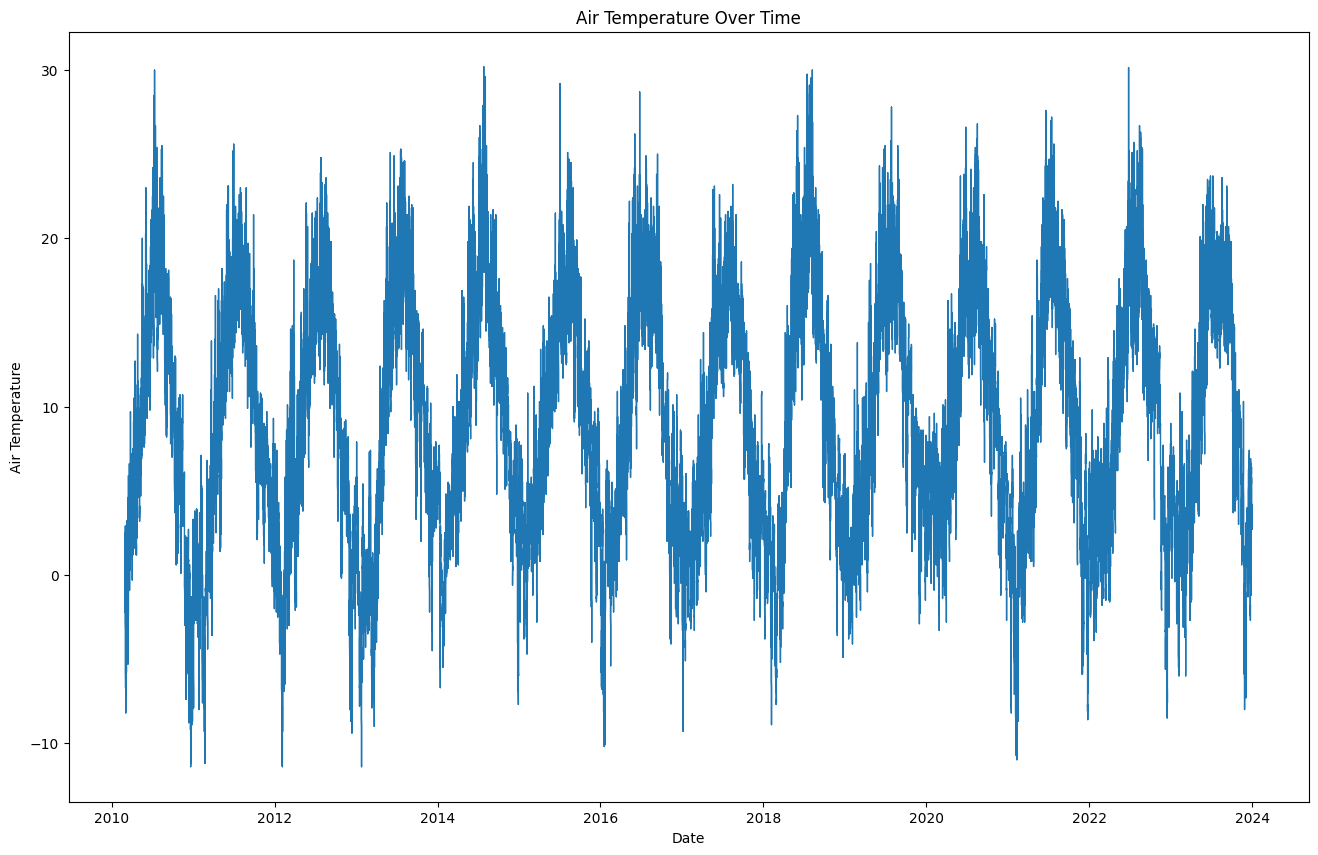

In [5]:
# Plot the temp/time
mpl.figure(figsize=(16, 10))
mpl.plot(smhi_df_cleaned["Datum"], smhi_df_cleaned["Lufttemperatur"], linewidth=1)
mpl.title('Air Temperature Over Time')
mpl.xlabel('Date')
mpl.ylabel('Air Temperature')
mpl.show()

Using matplotlib a plot of air temperature over time is from the cleaned dataset.

### Rank the overall temperature per month, sort from the coldest to the warmest. List the top ten (10) coldest months in the dataset. Format the output as: YEAR/Month: temp, e.g.“2010/January: -5.0”

In [6]:
# Calculate daily average temperature
daily_avg = smhi_df_cleaned['Lufttemperatur'].groupby(smhi_df_cleaned["Datum"]).mean()

# Calculate monthly average temperature
monthly_avg = daily_avg.resample('M').mean()

# Get the 10 coldest months
coldest_10_temp = monthly_avg.sort_values().head(10)

# Print the 10 coldest months
for date, temp in coldest_10_temp.items():
    print(f"{date.strftime('%Y/%B')}: {temp:.1f}")


2010/December: -3.7
2011/February: -1.5
2012/February: -1.3
2021/February: -0.9
2018/February: -0.9
2016/January: -0.9
2013/March: -0.8
2013/January: -0.6
2012/December: -0.6
2013/February: -0.4


Firstly data is grouped by date and time, then the daily average ic calculated. The daily average is then used to calculate the monthly average. The values in the monthly averages are then sorted and the 10 first values in the data (in this case the coldest/lowest) are stored in a variable. The 10 coldest months are then printed in the desired format.

### Which distribution is suitable to consider to fit the air temperature data? How well does the data follow that distribution given some measure, e.g., p-value?

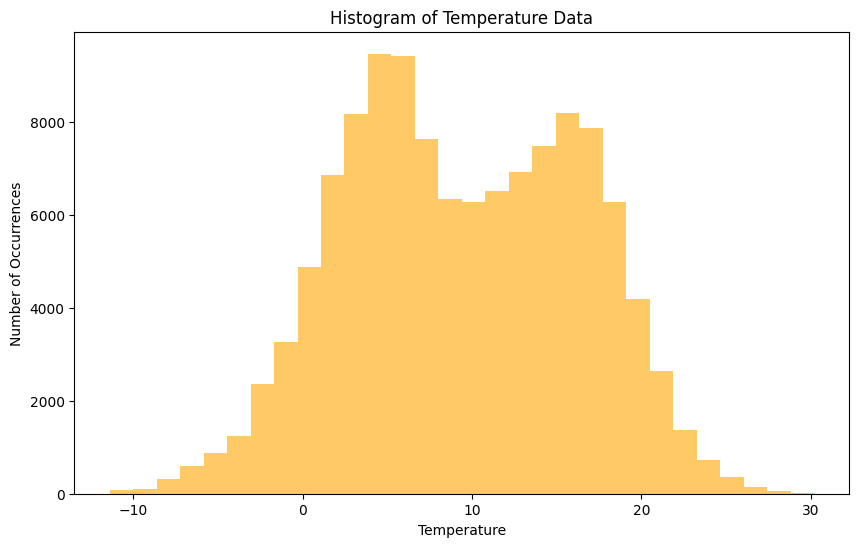

In [ ]:
# Plot air temperature with 60 bins to visualize the distribution of the temperature in the dataset
mpl.figure(figsize=(10, 6))
mpl.hist(smhi_df_cleaned["Lufttemperatur"], bins=30, alpha=0.6, color="orange")
mpl.xlabel('Temperature')
mpl.ylabel('Number of Occurrences')
mpl.title("Histogram of Temperature Data")
mpl.show()

When viewing the visualized data one can observe two distinct peaks, which could indicate that the data as a whole isn't following any distribution, but that the data might inlcude several different parts with their own distributions. When examining temperature data this isn't strange at all, since temperature natually varies depending on the time of the year. Visualizing the four different seasons might reveal any differences in temperature that can cause more than one peak of the general histogram.

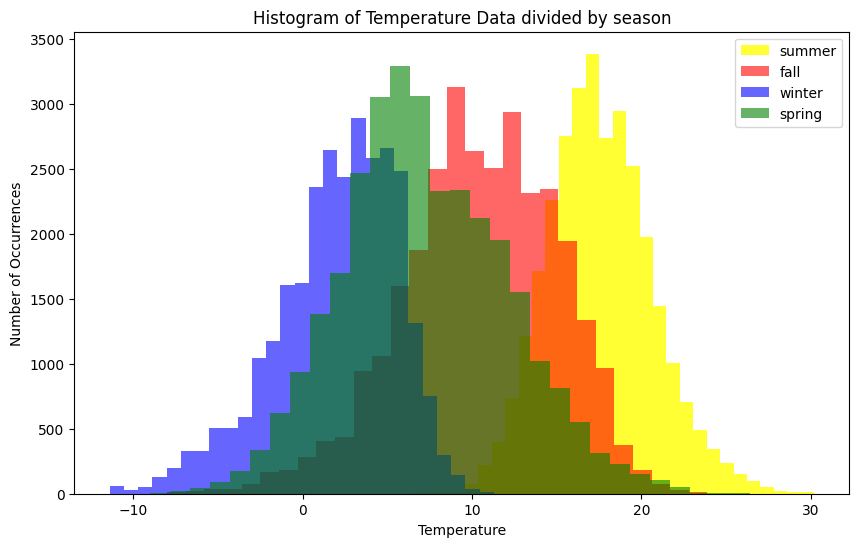

In [ ]:
# We observe more than one peak, which indicates that parts of the data might individually be normally (or any other type) distributed
# This makes sense since different seasons have different temperature ranges. We thusly choose to examine each season individually too

season_list = ["summer", "fall", "winter", "spring"] # List of season names
spring_temps = smhi_df_cleaned["Lufttemperatur"][(smhi_df_cleaned["Datum"].dt.month >= 3) & (smhi_df_cleaned["Datum"].dt.month <= 5)] # Extract spring temperatures
summer_temps = smhi_df_cleaned["Lufttemperatur"][(smhi_df_cleaned["Datum"].dt.month >= 6) & (smhi_df_cleaned["Datum"].dt.month <= 8)] # Extract summer temperatures
fall_temps = smhi_df_cleaned["Lufttemperatur"][(smhi_df_cleaned["Datum"].dt.month >= 9) & (smhi_df_cleaned["Datum"].dt.month <= 11)] # Extract fall temperatures
winter_temps = smhi_df_cleaned["Lufttemperatur"][(smhi_df_cleaned["Datum"].dt.month == 12) | (smhi_df_cleaned["Datum"].dt.month <= 2)] # Extract winter temperatures

# Create a histogram for each season
mpl.figure(figsize=(10, 6))
mpl.hist(summer_temps, bins=30, alpha=0.8, color='yellow')
mpl.hist(fall_temps, bins=30, alpha=0.6, color='red')
mpl.hist(winter_temps, bins=30, alpha=0.6, color='blue')
mpl.hist(spring_temps, bins=30, alpha=0.6, color='green')
mpl.xlabel('Temperature')
mpl.ylabel('Number of Occurrences')
mpl.title("Histogram of Temperature Data divided by season")
mpl.legend(season_list)
mpl.show()



As expected, visualizing the seasons individually reveals that they might be normally distributed individually. In order to test this hypothesis a test can be performed. However, testing for normality on large datasets (such as ours) will most likely result in a rejection even if our data would be perfectly normal. A good strategy would instead be to examine kurtosis and skew with relevant tests.

In [ ]:
# Standardize data for use with ztest
spring_temps_standardized = spring_temps
summer_temps_standardized = summer_temps
fall_temps_standardized = fall_temps
winter_temps_standardized = winter_temps
standardized_seasons_list = [summer_temps_standardized, fall_temps_standardized, winter_temps_standardized, spring_temps_standardized]

# Perform normality, skewness and kurtiosis test on each individual dataset (season)
for i, season in enumerate(standardized_seasons_list):
    res = st.normaltest(season, nan_policy='raise')
    print("\n")
    print(f"Normaltest for  {season_list[i]} gives p_value of: {res.pvalue}")
    print(f"Skewness of {season_list[i]}: {season.skew()}")
    print(f"Kurtosis of {season_list[i]}: {season.kurtosis()}")






Normaltest for  summer gives p_value of: 1.5469730864781825e-120
Skewness of summer: 0.31677878125708053
Kurtosis of summer: 0.2470696043109899


Normaltest for  fall gives p_value of: 6.167685693082397e-155
Skewness of fall: -0.3798007082767997
Kurtosis of fall: 0.1533926721834371


Normaltest for  winter gives p_value of: 0.0
Skewness of winter: -0.6949564525932872
Kurtosis of winter: 0.34647495464612144


Normaltest for  spring gives p_value of: 3.3718060927153505e-59
Skewness of spring: 0.23144005156628294
Kurtosis of spring: -0.03882037589641785


Since acceptable levels of skewness are within +-0.5 (for approximate symmetry) or within +- 0.5-1 (for moderate skew), and acceptable levels of kurtiosis are +-3, all of the seasons are within acceptable limits for what can be called normal. This together with a visual examination of the histograms of the seasons leads to the conclusions that when divided into separate seasons, the data can be considered normally distributed. However, the data as a whole doesn't seem to fit into what can be considered normal.

### Do you regard any of the air temperature measures in the dataset to be extreme values/outliers? If so, how many values? Motivate why you consider these values as anomalies.

In [ ]:
# Print the number of outliers that was handled during the data cleaning step in question 1, 
# using the variable number_outliers_removed that calculated the number of outliers removed
print(f"Number of outliers found during cleaning of data: {number_outliers_removed}")

Number of outliers found during cleaning of data: 205


When cleaning the data and performing the outlier handling (removing them and interpolating the values instead, thus preserving the integrity of the time series) the number of outliers "removed" was calculated and saved in a variable "number_outliers_removed". All values that had a z score above 3 was considered outliers. This should consider any values in the 1% extremes as outliers. 1% extremes was chosen because it preserved the overall shape of the time series Temperature per Time plot, but still caught the worst outliers, whereas a z score of 2 (5 % extremes) did alter the data too greatly and effectively normalized the data making it harder to visualize and possibly altering any analysis performed on it. 1% extremes is also a sound number since realistically temperature does vary quite alot, and some seasons/months are naturally volataile. Removal of an excessive amount of these volataile variations risks altering the data and losing an important part of how the air temperature changes.

### Calculate the mean temperature for each day in the year 2023 and then plot those means using a line plot with dates on the x-axis.

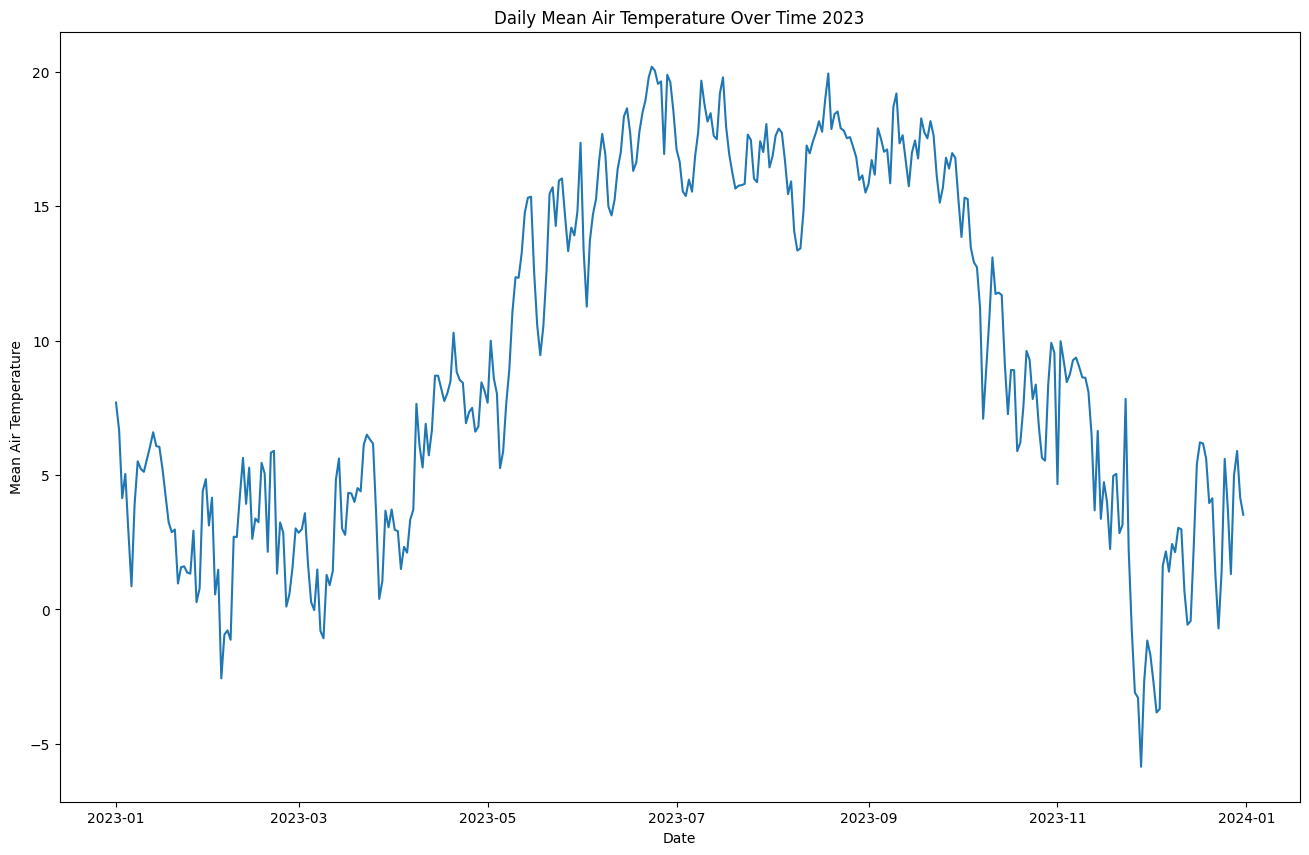

In [ ]:
# Use the daily average from question 6 to find the mean temperature over time during 2023
daily_avg_2023 = daily_avg[(daily_avg.index.get_level_values(0).year > 2022) & (daily_avg.index.get_level_values(0).year <=2023)]

# Plot mean temp over time during 2023
mpl.figure(figsize=(16, 10))
mpl.title('Daily Mean Air Temperature Over Time 2023')
mpl.xlabel('Date')
mpl.ylabel('Mean Air Temperature')
mpl.plot(daily_avg_2023, linewidth=1.5)
mpl.show()


By filtering the daily average data by year, a new dataset only containing the year 2023 was created. This dataset was then plotted using the plot function fronm matplotlib. 

### Rank the overall temperature per two (2) consecutive months startingwith the warmest 2-month period first, After that, you should sort those meansfrom highest to lowest and list the ten (10) warmest 2-month periods alltogether in the dataset

In [ ]:
# Use the rolling function to get two month intervals and take the mean of them
# in order to create a new dataframe with the 2-month averages. We reused the monthly average from question 6
monthly_2month_avg = monthly_avg.rolling(window=2).mean()

#Rename into double month names since it is easier to understand
month_dict = {}
month_names = {1: "January-February", 2: "February-March", 3: "March-April", 4: "April-May", 5: "May-June", 6: "June-July", 7: "July-August", 8: "August-September", 9: "September-October", 10: "October-November", 11: "November-December", 12: "December-January"}
for date, temp in monthly_2month_avg.items():
    month_dict[str(month_names[date.month]) + " " + str(date.year)] = temp

# Make dict into a pandas dataframe and sort it
month_dict = pd.DataFrame(month_dict, index=[0])
month_dict = month_dict.transpose()
month_dict.columns = ["Lufttemperatur"]
month_dict = month_dict.sort_values(by="Lufttemperatur", ascending=False)

# Use head to grab the 10 highest values and then print it out in a better looking format
top_10_warmest_2month = month_dict.head(10)
print("Top 10 warmest 2-month periods: \n")
for date, temp in top_10_warmest_2month.iterrows():
    print(f"{date}: {temp['Lufttemperatur']}")


Top 10 warmest 2-month periods: 

August-September 2018: 20.59875988142292
July-August 2018: 19.64111123190935
July-August 2021: 19.464563366838078
August-September 2014: 19.19939466405026
August-September 2010: 18.85033048219517
August-September 2021: 18.65865115920778
August-September 2022: 18.494635343618512
August-September 2019: 18.374623375105486
August-September 2013: 18.25980577539571
July-August 2014: 18.020673104131294


First the rolling function and mean function from pandas was used on the monthly average dataset, creating a new dataset containing the mean of each two month interval. A dictionary with all the name combinations is then created, which is then used together with the dataset containing the values of each two month interval to create a new dictionary containing the data toegther with a better naming scheme than the raw data. This dictionary is then made into a pandas dataframe instead, to allow us to make use of the .head fucntion to grab the 10 warmest two month periods. A for loop is then used to print it out in a better looking format.

### Calculate the 95% confidence intervals (CI) for the mean of each daily average in Q9 and add it to the line plot that shows the mean values of each day of the year 2023. You can, for example, solve this by plotting the upper and lower bounds as lines above and below the mean line in your plot. Another more nicely looking solution is to visualize the CI as shades around the mean line in your plot

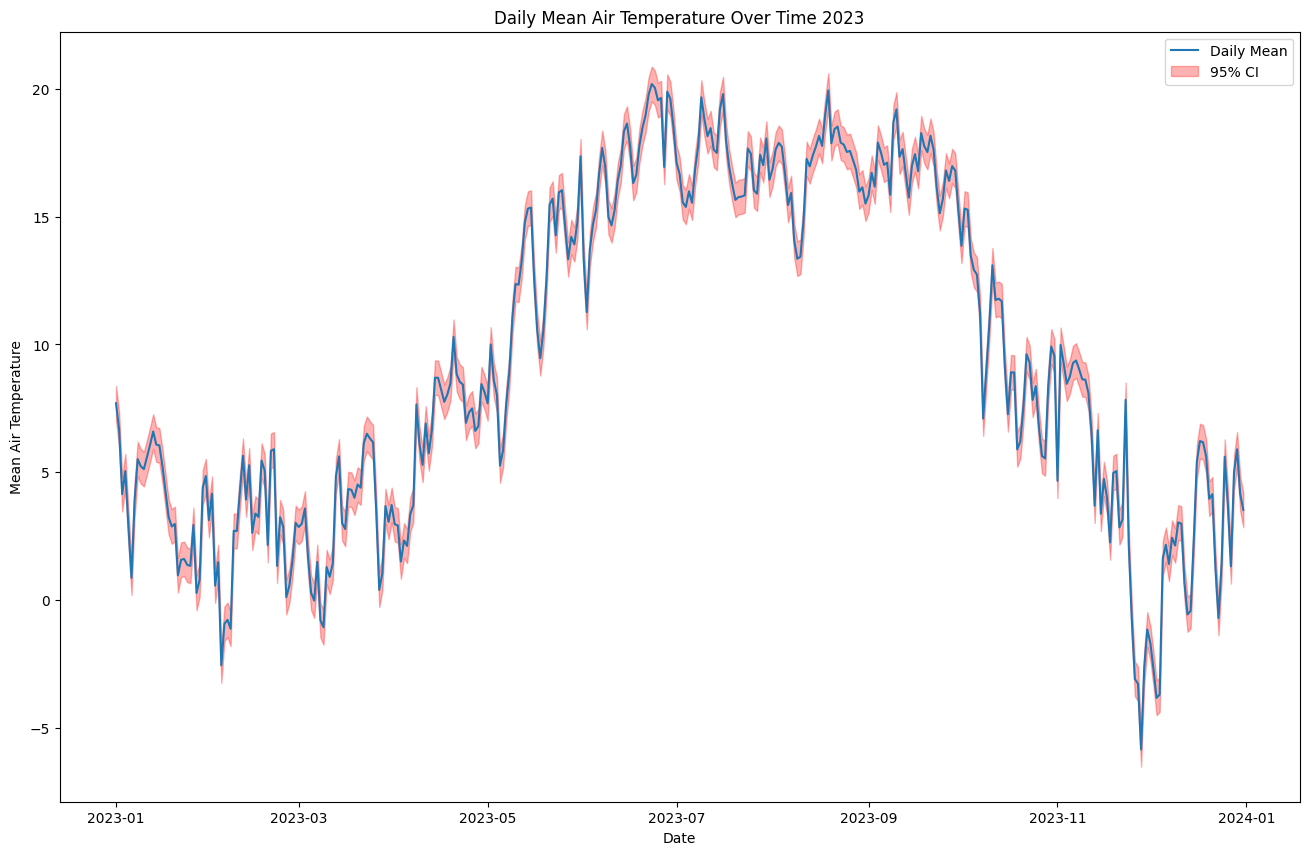

In [ ]:
# Calculate the 95% confidence interval for the mean using sem and mean
n = len(daily_avg_2023)
m, sem = daily_avg_2023.mean(), daily_avg_2023.sem()
confidence_interval = sem * st.t.ppf((1 + 0.95) / 2., n-1)

# Calculate the lower and upper bounds for the confidence interval at each point in time
upper_bound = daily_avg_2023 + confidence_interval
lower_bound = daily_avg_2023 - confidence_interval

# Plot mean temp over time (during 2023) with confidence interval in red
mpl.figure(figsize=(16, 10))
mpl.plot(daily_avg_2023.index, daily_avg_2023, linewidth=1.5, label='Daily Mean')
mpl.fill_between(daily_avg_2023.index, lower_bound, upper_bound, color='red', alpha=0.3, label='95% CI')
mpl.title('Daily Mean Air Temperature Over Time 2023')
mpl.xlabel('Date')
mpl.ylabel('Mean Air Temperature')
mpl.legend()
mpl.show()


The confidence interval was created by using n (number of instances), m (mean) and sem (standard error of mean) by using the len function and the .mean amd .sem fucntions of the pandas dataframe. The confidence interval is then calculated and applied with addition and subtraction to the whole dataset in order to create the upper and lower bounds. In addition to the normal 2023 plot from Q9, a shaded area is also plotted using .fill_between function of matplotlib and the lower and upper bounds, in order to easily visualize the 95% confidence interval.